### Sunny Shah (sunnymshah95@gmail.com)
In this Jupyter notebook, I create a machine learning strategy to predict future returns of HDFC Bank stock.

I use the following features as input for my ML model:   
1. RSI (relative strength index)    
2. EMA (exponentially-weighted moving average)    
3. ATR (average true range)    
4. Stochastic Oscillator    

In [1]:
import yfinance as yf
import numpy as np 
import pandas as pd 
from matplotlib import pyplot as plt
from sklearn.model_selection import KFold, cross_validate, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score

Here I download the historical prices of the stock with ticker _HDFCBANK.BO_. I will be working the Adjusted Closing Price - _Adj Close_.

In [2]:
data = yf.download(tickers = "HDFCBANK.BO", start = "2010-09-16", end = "2020-09-16")

print(data.head())

[*********************100%***********************]  1 of 1 completed
                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2010-09-16  237.009995  241.500000  235.600006  239.485001  201.275101   
2010-09-17  239.399994  242.279999  238.735001  239.964996  201.678528   
2010-09-20  239.800003  247.139999  239.800003  244.570007  205.548782   
2010-09-21  245.054993  249.320007  245.054993  247.070007  207.649918   
2010-09-22  247.399994  248.500000  245.009995  247.485001  207.998688   

             Volume  
Date                 
2010-09-16  3411860  
2010-09-17  1416700  
2010-09-20   757830  
2010-09-21  1651000  
2010-09-22   859670  


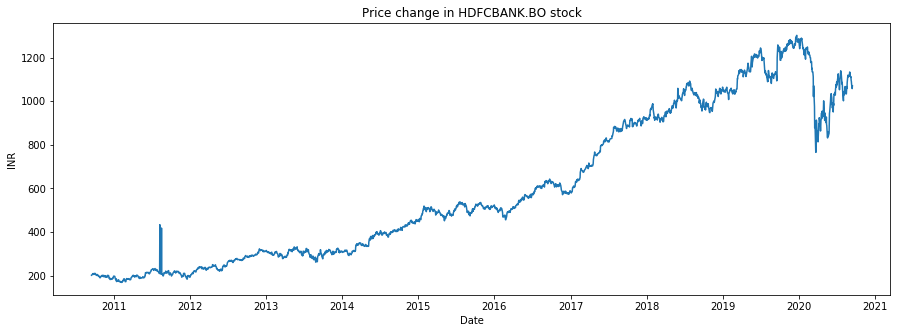

In [3]:
adj_close = data["Adj Close"]

plt.figure(figsize = (15, 5))
plt.plot(adj_close)
plt.xlabel("Date")
plt.ylabel("INR")
plt.title("Price change in HDFCBANK.BO stock")
plt.show()

Here, I set up the first feature - the [stochastic oscillator](https://www.investopedia.com/terms/s/stochasticoscillator.asp) (with period = 14 days).

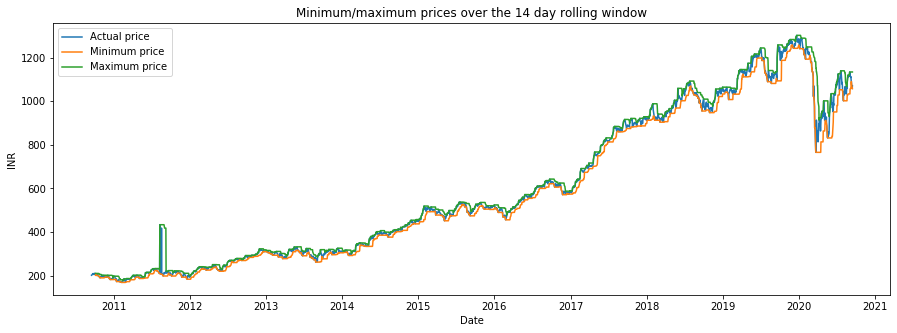

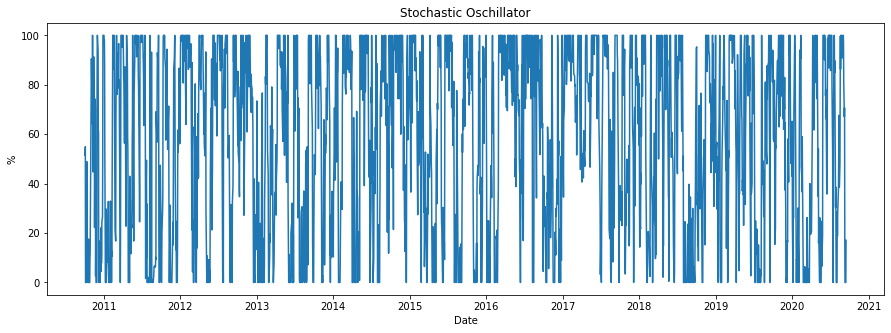

In [4]:
min_price = adj_close.rolling(14).min()
max_price = adj_close.rolling(14).max()

plt.figure(figsize = (15, 5))
plt.plot(adj_close, label = "Actual price")
plt.plot(min_price, label = "Minimum price")
plt.plot(max_price, label = "Maximum price")
plt.title("Minimum/maximum prices over the 14 day rolling window")
plt.xlabel("Date")
plt.ylabel("INR")
plt.legend()
plt.show()

stoch_osc = 100 * (adj_close - min_price) / (max_price - min_price)

data['OSC'] = stoch_osc

plt.figure(figsize = (15, 5))
plt.plot(stoch_osc)
plt.xlabel("Date")
plt.ylabel("%")
plt.title('Stochastic Oschillator')
plt.show()

I try to set up the second feature - the [RSI](https://www.investopedia.com/terms/r/rsi.asp) (with period = 14 days).

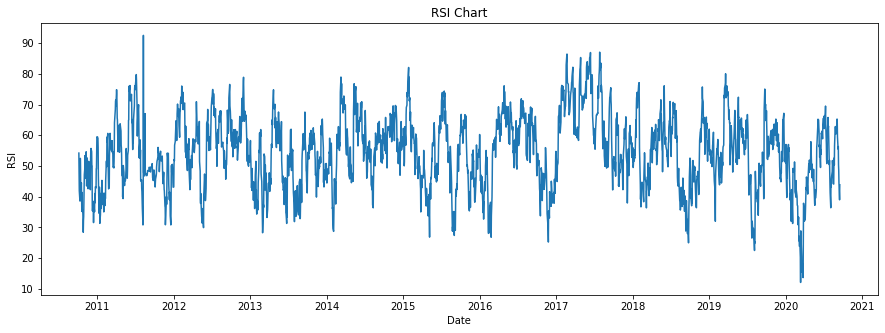

In [5]:
diff = adj_close.diff(1).dropna() # take differences and drop the missing values

gain = 0 * diff
loss = 0 * diff

gain[diff > 0] = diff[diff > 0]
loss[diff < 0] = diff[diff < 0]

avg_gain = gain.ewm(com = 13, min_periods = 14).mean()
avg_loss = loss.ewm(com = 13, min_periods = 14).mean()

rs = abs(avg_gain / avg_loss)
rsi = 100 - 100 / (1 + rs)

data['RSI'] = rsi 

plt.figure(figsize = (15, 5))
plt.plot(rsi)

plt.title("RSI Chart")
plt.xlabel("Date")
plt.ylabel("RSI")
plt.show()

I set up the third feature - the [ATR](https://www.investopedia.com/terms/a/atr.asp).

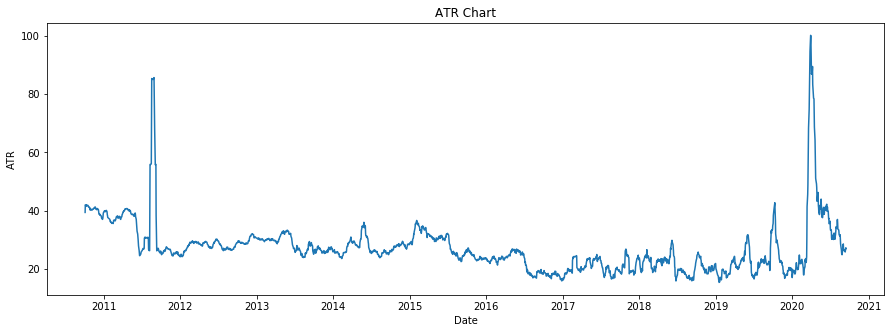

In [6]:
ATR_1 = data['High'] - data['Low']
ATR_2 = abs(data['High'] - data['Adj Close'].shift())
ATR_3 = abs(data['Low'] - data['Adj Close'].shift())

df = pd.concat([ATR_1, ATR_2, ATR_3], axis = 1)

ATR = df.max(axis = 1)
ATR = ATR.rolling(14).mean()

data['ATR'] = ATR

plt.figure(figsize = (15, 5))
plt.plot(ATR)
plt.title("ATR Chart")
plt.xlabel("Date")
plt.ylabel("ATR")
plt.show()

I finally set up the fourth and last feature - the [EMA](https://www.investopedia.com/terms/e/ema.asp).

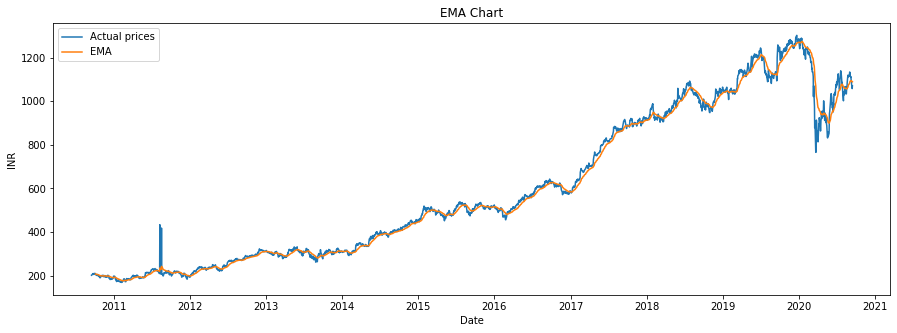

In [7]:
ema = adj_close.ewm(com = 13, min_periods = 14).mean() 
data['EMA'] = ema

plt.figure(figsize = (15, 5))
plt.plot(adj_close, label = "Actual prices")
plt.plot(ema, label = "EMA")
plt.title("EMA Chart")
plt.xlabel("Date")
plt.ylabel("INR")
plt.legend()
plt.show()

Finally, I create my label, "buy" or "sell", depending on the price difference between today's close price and yesterday's close price. If the difference is negative or 0 (bearish), then sell, aka set the label to "Sell". Otherwise set to "Buy".

In [8]:
signal = 0 * diff

signal[diff <= 0] = -1
signal[diff > 0] = 1

data['Signal'] = signal

I then get rid of the NaN values by ignoring the first 14 days' data.

In [9]:
data = data[14:]
print(data)

                   Open         High          Low        Close    Adj Close  \
Date                                                                          
2010-10-06   248.199997   248.199997   244.699997   245.445007   206.284180   
2010-10-07   245.990005   246.000000   242.524994   243.210007   204.405777   
2010-10-08   244.395004   244.600006   239.110001   240.345001   201.997894   
2010-10-11   242.399994   250.000000   237.050003   238.589996   200.522919   
2010-10-12   239.000000   239.000000   234.300003   238.589996   200.522919   
...                 ...          ...          ...          ...          ...   
2020-09-09  1101.000000  1111.050049  1091.699951  1095.699951  1095.699951   
2020-09-10  1105.000000  1105.000000  1084.000000  1090.650024  1090.650024   
2020-09-11  1094.000000  1104.949951  1071.099976  1078.500000  1078.500000   
2020-09-14  1090.000000  1093.900024  1053.199951  1057.900024  1057.900024   
2020-09-15  1066.000000  1076.000000  1058.400024  1

I then extract my features and labels and normalize my features. In addition, I also generate my training and test data. I plan on using the $k$-Nearest Neighbors algorithm to classify the data. Hence, I use the true signal and not the `y` below.

In [10]:
X = data[['RSI', 'EMA', 'OSC', 'ATR']]
y = data['Adj Close']

true_signals = data['Signal']

scaler = StandardScaler().fit(X)
X_norm = scaler.transform(X) # normalizing my features

x_train, x_test, y_train, y_test = train_test_split(X_norm, true_signals.to_numpy(), test_size = 0.2)

To classify my data, I decided to use the $k$-Nearest Neighbors classifier since I felt that it would be the best algorithm to separate the data set, given the 4 different features. I use the classifier, in conjunction with cross validation.

I first try to fit the model for $k = 5$ and then report the accuracy and F1 scores. Then, I try to find the optimum $k$ and plot the accuracy and F1 scores over all the different $k$'s.

In [11]:
knn = KNeighborsClassifier(n_neighbors = 5)
knn.fit(x_train, y_train)

cv = KFold(n_splits = 10, shuffle = True)

scores = cross_validate(knn, x_train, y_train, scoring = ['accuracy', 'f1'], cv = cv, n_jobs = -1)
print(f"Accuracy score: {np.mean(scores['test_accuracy']) : .5f} Standard deviation = {np.std(scores['test_accuracy']) : .5f}")
print(f"F1 score score: {np.mean(scores['test_f1']) : .5f} Standard deviation = {np.std(scores['test_f1']) : .5f}")

Accuracy score:  0.62769 Standard deviation =  0.03166
F1 score score:  0.63355 Standard deviation =  0.04982


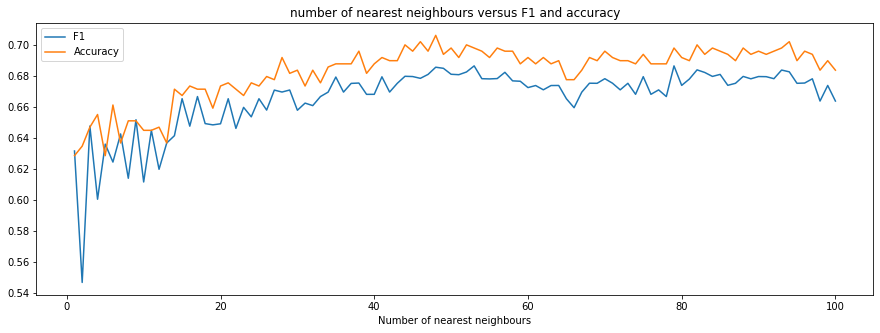

In [12]:
num_neighbors = range(1, 101)
f1_scores = []
accuracy_scores = []

for k in num_neighbors:
    knn = KNeighborsClassifier(n_neighbors = k)
    knn.fit(x_train, y_train)
    
    predicted_signals = knn.predict(x_test)
    
    f1_scores.append(f1_score(y_test, predicted_signals))
    accuracy_scores.append(knn.score(x_test, y_test))

plt.figure(figsize = (15, 5))
plt.plot(num_neighbors, f1_scores, label = 'F1')
plt.plot(num_neighbors, accuracy_scores, label = 'Accuracy')
plt.xlabel("Number of nearest neighbours")
plt.legend()
plt.title("number of nearest neighbours versus F1 and accuracy")
plt.show()

In [13]:
opt_k = np.argmax(np.array(accuracy_scores))

print(f"The optimal number of nearest neighbours is {opt_k + 1}, with the accuracy score being \
                                        {accuracy_scores[opt_k]:0.5f} and F1 score being {f1_scores[opt_k]:0.5f}.")

The optimal number of nearest neighbours is 48, with the accuracy score being                                         0.70612 and F1 score being 0.68559.


Therefore, we can see that the above KNN classifier has an accuracy score of 70.6% and a F1 score of 68.6%. This is an indicator of the model not overfitting (which is a good sign!). However, despite the low score, the above model could be improved by choosing more appropriate technical indicators as features, such as those that have a direct impact on the label of "sell" or "buy", since I may have oversimplified the process of assigning labels to the data. Another way of improving the model would be to deal with the NaN values appropriately, instead of disposing them as I did.